# Project 4: Plant Disease Detection

**Type:** Computer Vision | **Level:** Intermediate

Diagnose plant diseases from leaf images using deep learning.

**Model:** Transfer Learning (MobileNetV2)

**Dataset:** [PlantVillage Dataset](https://www.kaggle.com/datasets/emmarex/plantdisease)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, hamming_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


## 2. Load Data

In [2]:
# Load the dataset
train_df = pd.read_csv('../data/plant_disease/train.csv')
test_df = pd.read_csv('../data/plant_disease/test.csv')

# Image directory
img_dir = '../data/plant_disease/images/'

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nColumn names:\n{train_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_df.head(10))

# Disease classes
disease_classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
print(f"\nDisease classes: {disease_classes}")

Training data shape: (1821, 5)
Test data shape: (1821, 1)

Column names:
['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']

First few rows:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
5  Train_5        1                  0     0     0
6  Train_6        0                  1     0     0
7  Train_7        0                  0     0     1
8  Train_8        0                  0     0     1
9  Train_9        1                  0     0     0

Disease classes: ['healthy', 'multiple_diseases', 'rust', 'scab']


## 3. Exploratory Data Analysis

Class Distribution:
  healthy: 516 (28.3%)
  multiple_diseases: 91 (5.0%)
  rust: 622 (34.2%)
  scab: 592 (32.5%)


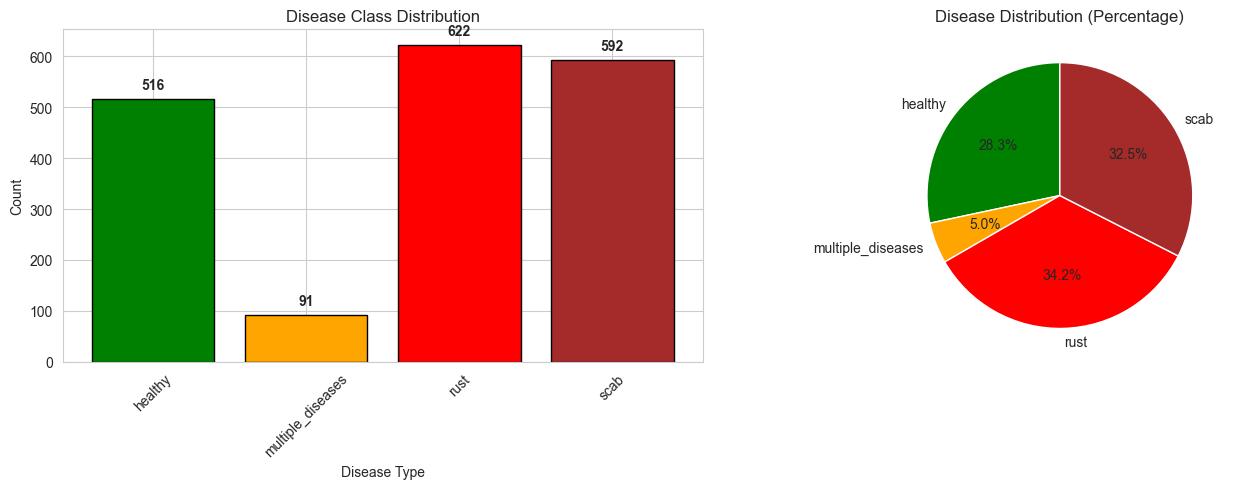


Sample Images:


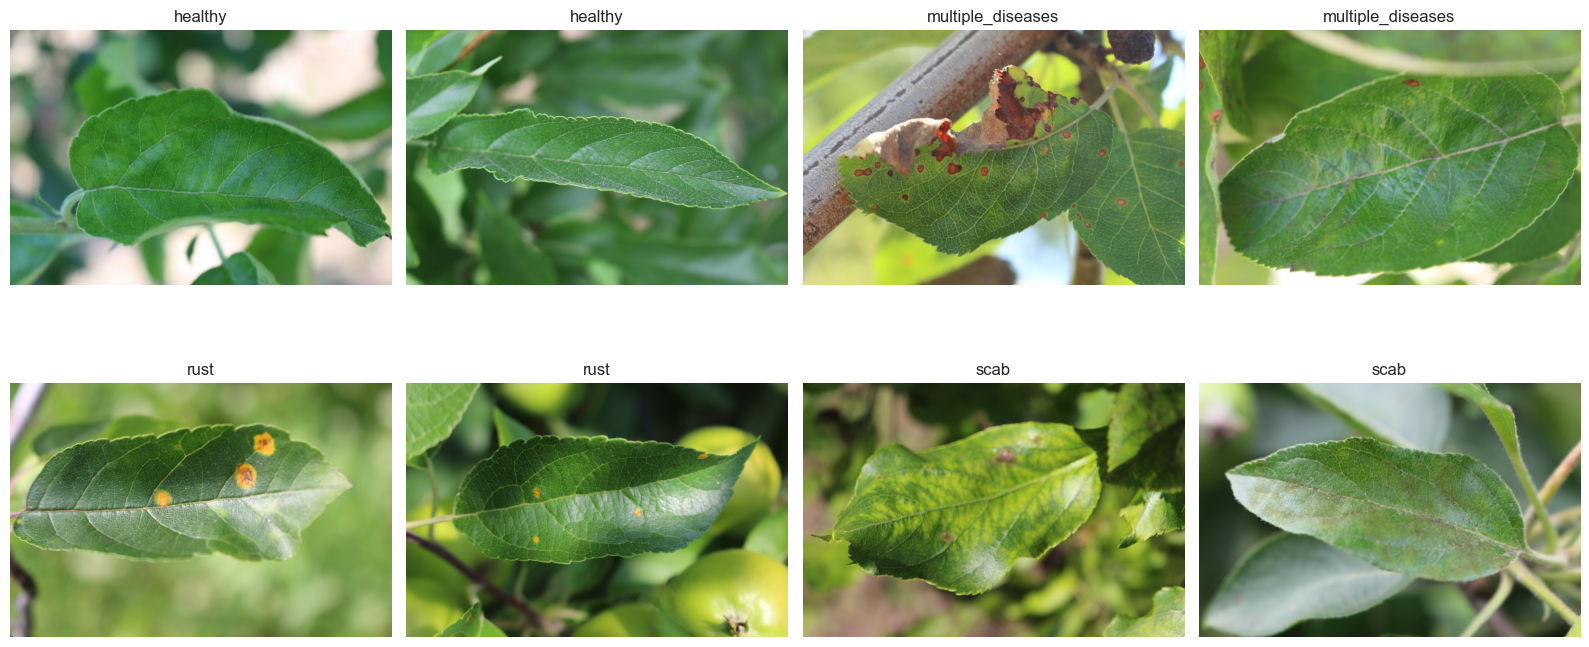

In [3]:
# Analyze class distribution
print("Class Distribution:")
for col in disease_classes:
    count = train_df[col].sum()
    percentage = (count / len(train_df)) * 100
    print(f"  {col}: {count} ({percentage:.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of disease counts
disease_counts = train_df[disease_classes].sum()
axes[0].bar(disease_classes, disease_counts, color=['green', 'orange', 'red', 'brown'], edgecolor='black')
axes[0].set_title('Disease Class Distribution')
axes[0].set_xlabel('Disease Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(disease_counts):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(disease_counts, labels=disease_classes, autopct='%1.1f%%', 
            colors=['green', 'orange', 'red', 'brown'], startangle=90)
axes[1].set_title('Disease Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Display sample images
print("\nSample Images:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, disease in enumerate(disease_classes):
    # Get 2 samples of each disease
    samples = train_df[train_df[disease] == 1].head(2)
    
    for j, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['image_id'] + '.jpg')
        img = Image.open(img_path)
        
        ax_idx = i * 2 + j
        axes[ax_idx].imshow(img)
        axes[ax_idx].set_title(f"{disease}")
        axes[ax_idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [4]:
# Prepare data for training
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32

# Split train data into train and validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Function to load and preprocess images
def load_image(image_id, img_size=IMG_SIZE):
    img_path = os.path.join(img_dir, image_id + '.jpg')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Create data generators
def data_generator(dataframe, batch_size, is_training=True):
    while True:
        # Shuffle if training
        if is_training:
            dataframe = dataframe.sample(frac=1).reset_index(drop=True)
        
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_df = dataframe.iloc[start:end]
            
            # Load images
            images = np.array([load_image(img_id) for img_id in batch_df['image_id']])
            
            # Get labels
            labels = batch_df[disease_classes].values
            
            yield images, labels

print("\nData preprocessing complete!")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")

Training samples: 1456
Validation samples: 365

Data preprocessing complete!
Image size: 224x224
Batch size: 32


## 5. Model Training

In [5]:
# Build model using Transfer Learning (MobileNetV2)
print("Building model...")

# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(disease_classes), activation='sigmoid')  # Sigmoid for multi-label
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Binary crossentropy for multi-label
    metrics=['accuracy']
)

print("\n" + "="*60)
print("Model built successfully!")
print("="*60)
print(f"Base model: MobileNetV2 (pre-trained on ImageNet)")
print(f"Output classes: {len(disease_classes)}")

# Train the model (small number of epochs for quick training)
EPOCHS = 5
steps_per_epoch = len(train_data) // BATCH_SIZE
validation_steps = len(val_data) // BATCH_SIZE

print(f"\nTraining for {EPOCHS} epochs...")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Create generators
train_gen = data_generator(train_data, BATCH_SIZE, is_training=True)
val_gen = data_generator(val_data, BATCH_SIZE, is_training=False)

# Train
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    verbose=1
)

print("\nTraining complete!")

Building model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model built successfully!
Base model: MobileNetV2 (pre-trained on ImageNet)
Output classes: 4

Training for 5 epochs...
Steps per epoch: 45
Validation steps: 11
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - accuracy: 0.6479 - loss: 0.4018 - val_accuracy: 0.7784 - val_loss: 0.2896
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.8139 - loss: 0.2664 - val_accuracy: 0.8239 - val_loss: 0.2400
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.8434 - loss: 0.2237 - val_accuracy: 0.8295 - val_loss: 0.2292
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.8279 - loss: 0.2217 - val_accuracy: 0.8348 - val_loss: 0.2208
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.8504 - loss: 0.1978 - val_accuracy: 0.8498 - val_loss: 0.1970

Training complete!


## 6. Model Evaluation

Evaluating model on validation set...

Model Performance:
Hamming Loss: 0.0781
Exact Match Accuracy: 0.7945

Per-Class Performance:
  healthy: 0.9260
  multiple_diseases: 0.9507
  rust: 0.9315
  scab: 0.8795


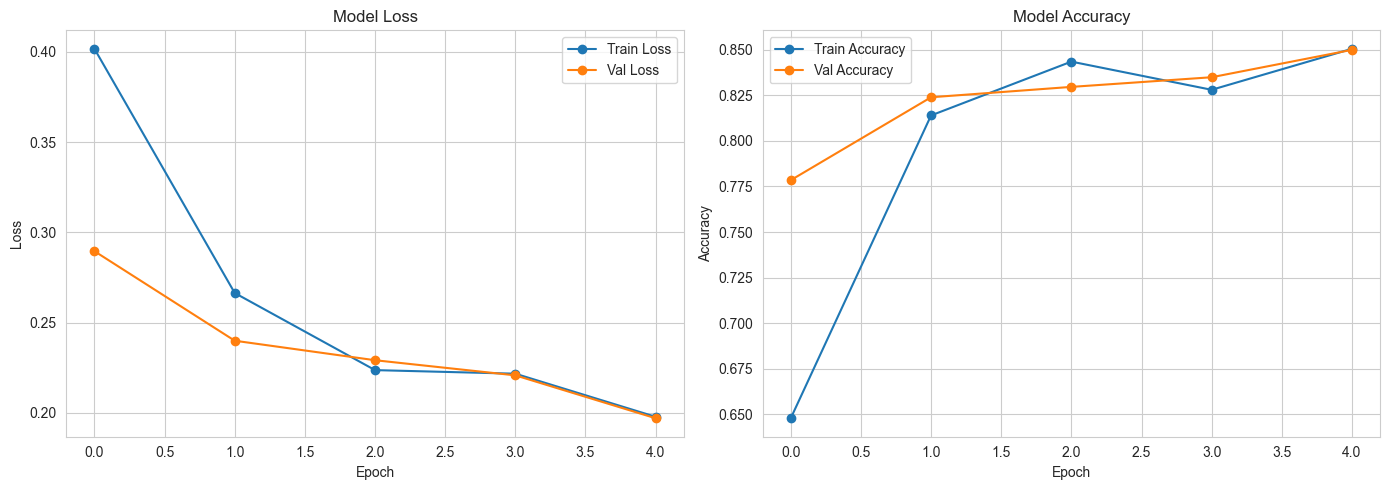


Sample Predictions:


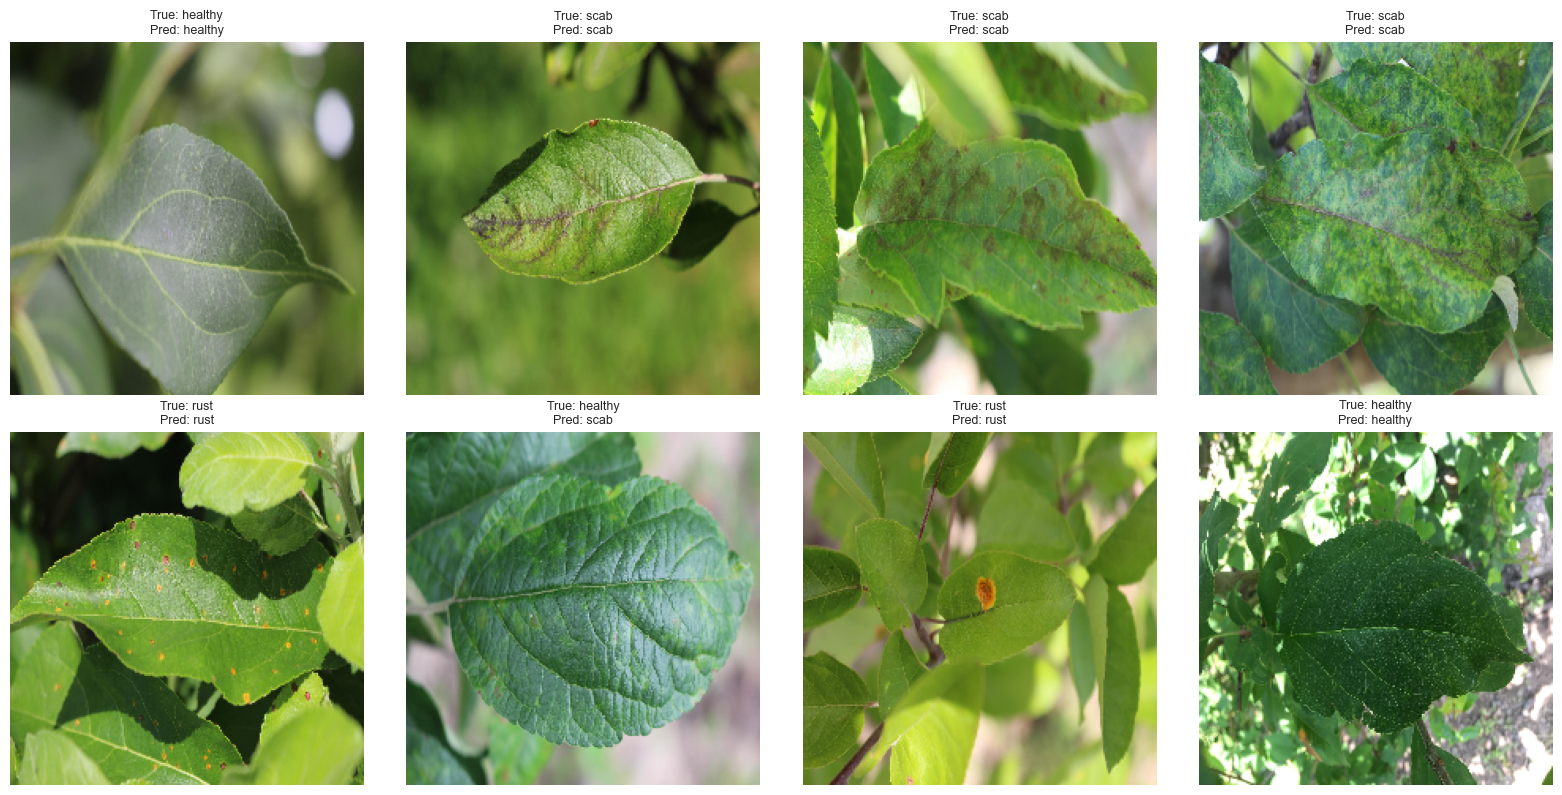

In [6]:
# Evaluate the model
print("Evaluating model on validation set...")

# Make predictions on validation set
val_images = np.array([load_image(img_id) for img_id in val_data['image_id'].values])
val_labels = val_data[disease_classes].values

predictions = model.predict(val_images, verbose=0)
predictions_binary = (predictions > 0.5).astype(int)

# Calculate metrics
hamming = hamming_loss(val_labels, predictions_binary)
accuracy = accuracy_score(val_labels, predictions_binary)

print("\n" + "="*60)
print("Model Performance:")
print("="*60)
print(f"Hamming Loss: {hamming:.4f}")
print(f"Exact Match Accuracy: {accuracy:.4f}")

# Per-class metrics
print("\nPer-Class Performance:")
for i, disease in enumerate(disease_classes):
    y_true = val_labels[:, i]
    y_pred = predictions_binary[:, i]
    class_acc = accuracy_score(y_true, y_pred)
    print(f"  {disease}: {class_acc:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='o')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Show some predictions
print("\nSample Predictions:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

sample_indices = np.random.choice(len(val_data), 8, replace=False)
for idx, ax in enumerate(axes):
    sample_idx = sample_indices[idx]
    img_id = val_data.iloc[sample_idx]['image_id']
    
    # Load and display image
    img = load_image(img_id)
    ax.imshow(img)
    
    # Get true and predicted labels
    true_labels = [disease_classes[i] for i, val in enumerate(val_labels[sample_idx]) if val == 1]
    pred_labels = [disease_classes[i] for i, val in enumerate(predictions_binary[sample_idx]) if val == 1]
    
    ax.set_title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. Save Model

In [7]:
# Save the model
model_path = '../models/plant_disease_model.h5'
model.save(model_path)
print(f"✓ Model saved to: {model_path}")

# Save model info
model_info = {
    'disease_classes': disease_classes,
    'img_size': IMG_SIZE,
    'model_architecture': 'MobileNetV2',
    'num_classes': len(disease_classes)
}

import joblib
info_path = '../models/plant_disease_info.pkl'
joblib.dump(model_info, info_path)
print(f"✓ Model info saved to: {info_path}")

print("\n" + "="*60)
print("Plant Disease Detection Model Complete!")
print("="*60)
print(f"Model type: Transfer Learning (MobileNetV2)")
print(f"Task: Multi-label classification")
print(f"Classes: {disease_classes}")
print(f"Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Validation accuracy: {accuracy:.2%}")

print("\n" + "="*60)
print("Example Usage:")
print("="*60)
print("""
# Load the model
from tensorflow import keras
import joblib

model = keras.models.load_model('../models/plant_disease_model.h5')
info = joblib.load('../models/plant_disease_info.pkl')

# Make prediction
import cv2
img = cv2.imread('path/to/image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)
predicted_diseases = [info['disease_classes'][i] 
                     for i, val in enumerate(predictions[0]) 
                     if val > 0.5]
print(f"Detected diseases: {predicted_diseases}")
""")

✓ Model saved to: ../models/plant_disease_model.h5
✓ Model info saved to: ../models/plant_disease_info.pkl

Plant Disease Detection Model Complete!
Model type: Transfer Learning (MobileNetV2)
Task: Multi-label classification
Classes: ['healthy', 'multiple_diseases', 'rust', 'scab']
Input size: 224x224
Validation accuracy: 79.45%

Example Usage:

# Load the model
from tensorflow import keras
import joblib

model = keras.models.load_model('../models/plant_disease_model.h5')
info = joblib.load('../models/plant_disease_info.pkl')

# Make prediction
import cv2
img = cv2.imread('path/to/image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)
predicted_diseases = [info['disease_classes'][i] 
                     for i, val in enumerate(predictions[0]) 
                     if val > 0.5]
print(f"Detected diseases: {predicted_diseases}")

